In [81]:
from Bio import PDB
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir(os.path.expanduser('~/projects/github-repos/protein-structure-proximity-network'))

In [35]:
def get_PDB_structure(pdb_id:str)->PDB.Structure.Structure:
    '''
    Takes a pdb id and returns its sructure

    Starts by retriving the pdb file, saving it in data/{pdb_id}/{pdb_id}.pdb
    then reads the file and returns the structure

    param:
    ------
    - pdb_id: str, pdb id of the structure to be retrived

    return:
    -------
    - structure: Bio.PDB.Structure.Structure, structure of the pdb file
    '''
    pdb_id=pdb_id.lower()
    pdb_list = PDB.PDBList()
    pdb_list.retrieve_pdb_file(pdb_id, pdir=f'data/{pdb_id}', file_format='pdb')
    os.rename(f'data/{pdb_id}/pdb{pdb_id}.ent', f'data/{pdb_id}/{pdb_id}.pdb')
        
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb_id, f'data/{pdb_id}/{pdb_id}.pdb')
    return structure

In [67]:
aa = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
    'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
    'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
    'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

def get_residues_coordinates(structure:PDB.Structure.Structure)->dict:
    '''
    takes a structure and returns a dictionary of the residues and their coordinates
    the coordinates are the coordinates of the alpha carbon

    param:
    ------
    - structure: Bio.PDB.Structure.Structure, structure of the pdb file

    return:
    -------
    - sequence: dict, dictionary of the residues and their coordinates
    '''

    sequence={}

    for model in s:
        for chain in model:
            for residue in chain:  
                # print(residue.get_id())  
                
                if residue.get_id()[0] != ' ':
                    continue                      
                aa_name=aa[residue.get_resname()]
                index=residue.get_id()[1] 

                res=aa_name+str(index)

                for atom in residue:
                    if atom.get_name() == 'CA':
                        alphaC_coord=list(atom.get_coord())
                        # print(atom.get_coord())
                        sequence[res]=alphaC_coord
    return sequence

In [92]:
import numpy as np

def euclidian_distance(c1:list, c2:list)->float:
    '''
    takes 2 vectors in 3D space and returns the euclidian distance between them

    param:
    ------
    - c1: list, list of 3 floats, coordinates of the first vector
    - c2: list, list of 3 floats, coordinates of the second vector

    $$\sqrt{{(coordinates_{1_1} - coordinates_{2_1})}^2 + {(coordinates_{1_2} - coordinates_{2_2})}^2 + {(coordinates_{1_3} - coordinates_{2_3})}^2}$$

    return:
    -------
    - distance: float, euclidian distance between the 2 points
    '''
    distance = ((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2)**0.5
    return distance

def visualize_map(df):
    '''takes a dataframe and viz as heatmap
    
    param:
    ------
    - df: pd.DataFrame

    return:
    -------
    - None
    '''
    plt.figure(figsize=(8,6))
    sns.heatmap(df, cmap='viridis')
    plt.xticks(rotation=70)
    plt.title('Contact Map of the residues in the protein')

    return None
    

def create_distance_map(sequence:dict)->np.array:
    '''
    takes a sequence of residues and their coordinates and returns a contact map

    param:
    ------
    - sequence: dict, dictionary of the residues and their coordinates

    return:
    -------
    - contact_map: pd.DataFrame, contact map of the residues
    '''
    contact_map = np.zeros((len(sequence), len(sequence)))
    for i, (res1, coord1) in enumerate(sequence.items()):
        for j, (res2, coord2) in enumerate(sequence.items()):
            contact_map[i][j] = euclidian_distance(coord1, coord2)
    df=pd.DataFrame(contact_map, index=sequence.keys(), columns=sequence.keys())

    visualize_map(df)
    
    return df


In [ ]:
def create_network(distance_df:pd.DataFrame, threshold=5):
    '''
    takes a distance map and establishes an edge whenever teh distance is $<$ threshold

    param:
    -----
    - distance_df: pd.DataFra
    '''

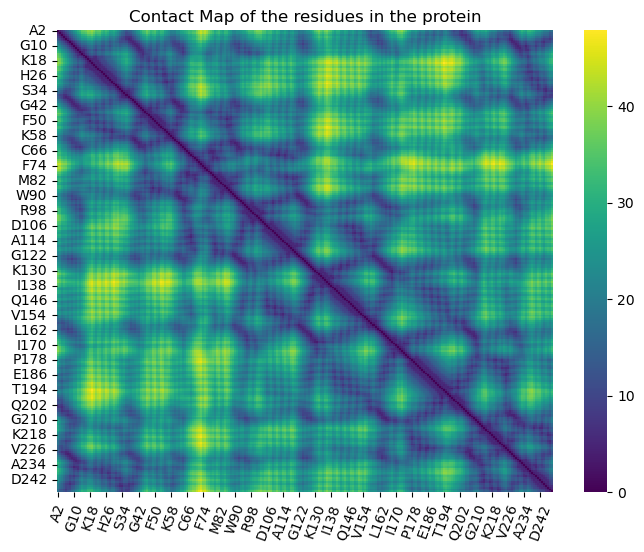

In [93]:
struct=get_PDB_structure('6xdc')
sequence=get_residues_coordinates(struct)
df=pd.DataFrame(create_distance_map(sequence), index=sequence.keys(), columns=sequence.keys())

(array([  0.5,   8.5,  16.5,  24.5,  32.5,  40.5,  48.5,  56.5,  64.5,
         72.5,  80.5,  88.5,  96.5, 104.5, 112.5, 120.5, 128.5, 136.5,
        144.5, 152.5, 160.5, 168.5, 176.5, 184.5, 192.5, 200.5, 208.5,
        216.5, 224.5, 232.5, 240.5]),
 [Text(0.5, 0, 'A2'),
  Text(8.5, 0, 'G10'),
  Text(16.5, 0, 'K18'),
  Text(24.5, 0, 'H26'),
  Text(32.5, 0, 'S34'),
  Text(40.5, 0, 'G42'),
  Text(48.5, 0, 'F50'),
  Text(56.5, 0, 'K58'),
  Text(64.5, 0, 'C66'),
  Text(72.5, 0, 'F74'),
  Text(80.5, 0, 'M82'),
  Text(88.5, 0, 'W90'),
  Text(96.5, 0, 'R98'),
  Text(104.5, 0, 'D106'),
  Text(112.5, 0, 'A114'),
  Text(120.5, 0, 'G122'),
  Text(128.5, 0, 'K130'),
  Text(136.5, 0, 'I138'),
  Text(144.5, 0, 'Q146'),
  Text(152.5, 0, 'V154'),
  Text(160.5, 0, 'L162'),
  Text(168.5, 0, 'I170'),
  Text(176.5, 0, 'P178'),
  Text(184.5, 0, 'E186'),
  Text(192.5, 0, 'T194'),
  Text(200.5, 0, 'Q202'),
  Text(208.5, 0, 'G210'),
  Text(216.5, 0, 'K218'),
  Text(224.5, 0, 'V226'),
  Text(232.5, 0, 'A234')

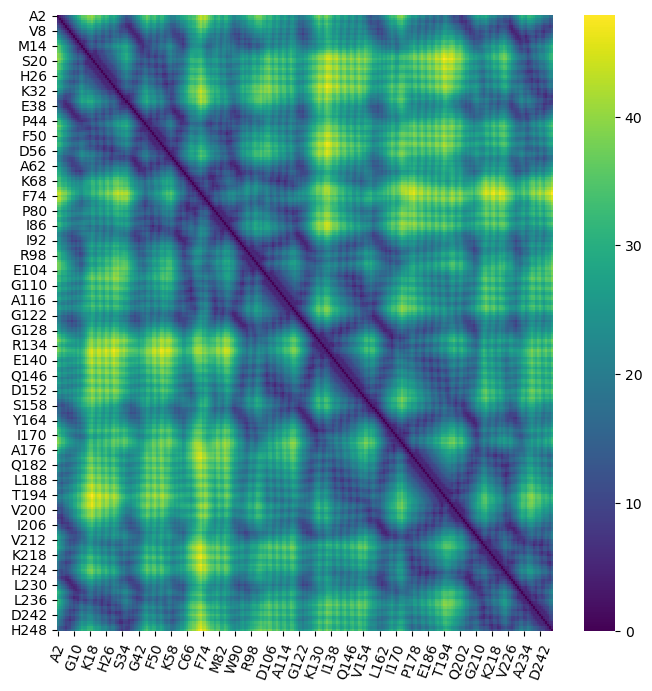

In [84]:
# visualize df as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.heatmap(df, cmap='viridis')
# make x ticks rotated 45 degrees
plt.xticks(rotation=70)

In [33]:
import nglview as nv

view = nv.show_biopython(structure)
view

NGLWidget()